# Cvičenie 8: Autoenkódery

Na dnešnom cvičení sa budeme zaoberať so špeciálnym prípadom nekontrolovaného učenia, ktorým sú autoenkódery. Autoenkódery sú neurónové siete, ktoré slúžia najmä na kompresiu údajov, avšak oproti tradičným metódam kompresie (RAR, ZIP, atď.) ich nepotrebujete vopred naprogramovať. Ich ďalšou vlastnosťou je, že sú špecificky určené na kompresiu údajov podobných dátam, na ktorých bola sieť natrénovaná. Tým pádom kompresia nie je univerzálne použiteľná, ale na druhej strane je často efektívnejšia, aj keď, podobne ako pri všetkých metódach kompresie, dochádza k strate pri kompresii.

Z topologického hľadiska sú autoenkódery zvyčajne symetrické (síce to nie je nevyhnutné, ale v praxi takéto siete sa trénujú jednoduchšie). Cieľom autoenkóderov je kopírovať vstup na výstupe tak, že skryté vrstvy majú menej neurónov ako vstup, resp. výstup. Autoenkódery teda majú dve časti: prvá je enkóder, ktorý skomprimuje údaje, kým druhá časť, teda dekóder ich reprodukuje zo zakódovaného tvaru.

![](https://github.com/DominikVranay/neural-networks-course/blob/master/labs/sources/lab09/9.1-autoencoder.png?raw=1)

Na dnešnom cvičení implementujeme jeden autoenkóder v PyTorch a vyskúšame jeho funkčnosť. Toto nám umožní ukázať, ako sa definujú siete v PyTorch ktoré potom rozdelíte na dve (alebo viac) časti.

## 1. Načítanie potrebných knižníc
V riešení využijeme už známe knižnice `torch`, `numpy` a `matplotlib`. Ako dataset použijeme MNIST dataset, ktorý obsahuje obrázky rukou písaných číslic. Tento dataset je ďalší štandardný dataset (najmä pre konvolučné siete), takže ho nájdeme v knižnici Torchvision. ktorá je nadstavba PyTorch knižnice pre manupulovanie s datasetmi. Pri prvom spustení kódu sa vám stiahne dataset, preto prvé spustenie môže trvať dlhšie.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

## 2. Vizualizácia výsledkov

V kóde máte pripravenú metódu `plot_results`, ktorá pomocou `matplotlib` vizualizuje výstup z jednotlivých častí siete (vstup, enkódovaný obraz, dekódovaný obraz). Metóda ukáže niekoľko (*n*) ukážkových vstupov, ich zakódovaný tvar, a rekonštruovaný obraz.

In [2]:
def plot_results(x_test, encoded_imgs, decoded_imgs, n=10):
    plt.figure(figsize=(40, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i, 0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(8, 4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(decoded_imgs[i, 0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## 3. Predspracovanie údajov

Keďže dnes nebudeme používať konvolúciu, dataset musíme upraviť tak, aby obrázky boli reprezentované ako jednorozmerné vektory. Originálne MNIST dataset obsahuje obrázky *28x28*, ktoré mi prekonvertujeme na tvar *(1x)784*. Pred tým ale pixely normalizujeme, t.j. pretypujeme ich na torchovský float - pixelové hodnoty od 0 po 255 namapujeme do intervalu 0 až 1.
Taktiež si vytvoríme loadery, ktoré nám budú dávkovať dáta v batchoch.

In [3]:
trainset = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testset = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\train-images-idx3-ubyte.gz to /files/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\train-labels-idx1-ubyte.gz to /files/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\t10k-images-idx3-ubyte.gz to /files/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST\raw\t10k-labels-idx1-ubyte.gz to /files/MNIST\raw



## 4. Definícia autoenkódera

V ďalšom kroku zadefinujeme autoenkóder s jednou skrytou vrstvou (neskôr tento kód môžete opraviť a rozšíriť model o ďalšie vrstvy).

### 4.1. Definícia modelov encoder a decoder

V tomto kroku zadefinujeme 2 modely: enkóder a dekóder. Každý bude vytvorený pomocou vlastného sekvenčného modela.

In [4]:
encoder = torch.nn.Sequential(torch.nn.Flatten(),
                              torch.nn.Linear(784, 256),
                              torch.nn.ReLU(),
                              torch.nn.Linear(256,128),
                              torch.nn.ReLU(),
                              torch.nn.Linear(128, 32)) # pridať vrstvy
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.all = torch.nn.Sequential(torch.nn.Linear(32, 128),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(128, 256),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(256, 784),
                                       torch.nn.Sigmoid()) # pridať vrstvy
        
    
    def forward(self, x):
        x = self.all(x).view(-1, 1, 28, 28)
        return x
decoder = Decoder()

### 4.2. Definícia spojeného modelu
Definícia spoločného modelu je menej priamočiara. Keďže sa bude trénovať ako jeden celok a potrebuje mať spoločné váhy s už vytvorenými modelami, vytvoríme ho pomocou vlastnej triedy, ktorá bude mať encoder a decoder model ako parametre.

In [5]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AutoEncoder(encoder, decoder)

### 4.3. Trénovanie autoenkódera

Neostáva nám nič iné, len natrénovať našu sieť. Pridajte chýbajúce parametre do volaní funkcií nasledovne:
* optimizer - napr. adam
* criterion - napr. binary crossentropy
* input - vstup autoenkódera (28x28)
* output - očakávaný výstup autoenkódera (28x28)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
for epoch in range(11):
    ls = []
    for inputs, _ in trainloader:
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, inputs)
        loss.backward()
        optimizer.step()
        ls.append(loss.detach().item())
    if epoch % 10 == 0:
        print("Loss:", sum(ls)/len(ls))

Loss: 0.2648652142666756
Loss: 0.09428311522970809


### 4.4. Testovanie autoenkódera

Ak už máme autoenkóder natrénovaný, môžeme vizualizovať jeho funkčnosť. Zavoláme funkciu `predict` nad testovacou množinou. Keďže chceme vizualizovať vstup, zakódovanú reprezentáciu, aj výstup autoenkódera, funkciu potrebujeme zavolať aj pre enkóder aj pre samotný autoenkóder. Ak chcete testovať zvlášť aj dekóder, upravte kód podľa potreby.

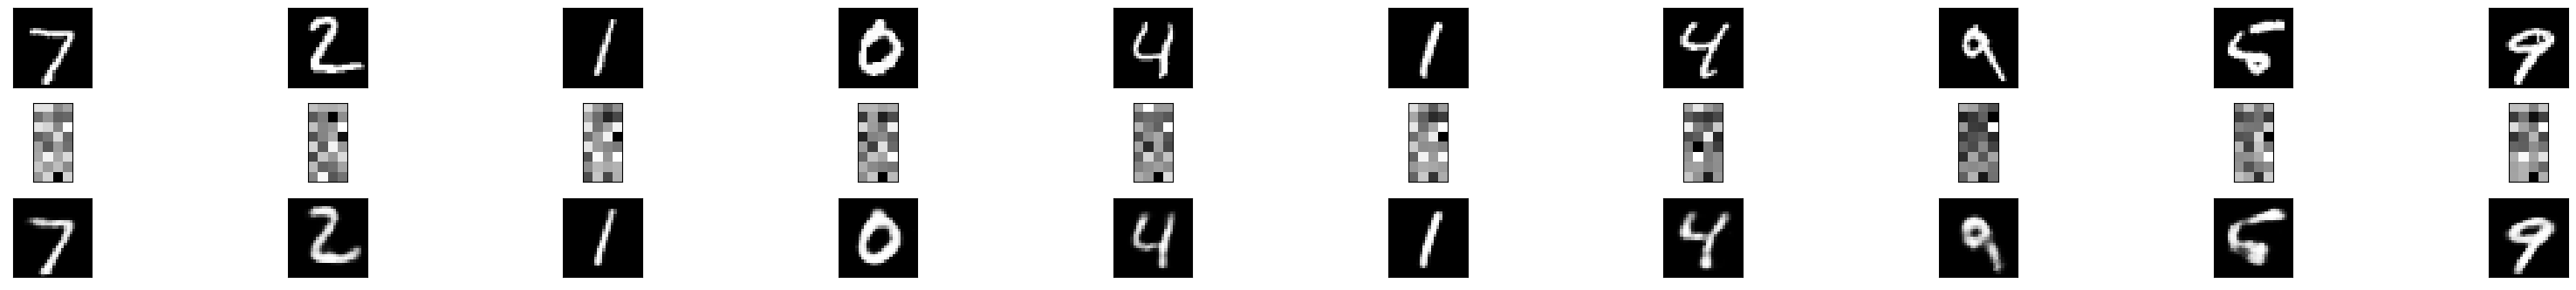

In [7]:
inputs, _ = next(iter(testloader))
encoded_imgs = encoder(inputs)
decoded_imgs = decoder(encoded_imgs)
#decoded_imgs = autoencoder.predict(x_test)

plot_results(inputs, encoded_imgs.detach().numpy(), decoded_imgs.detach().numpy())

Zobrazia sa nám tri riadky obrázkov, kde prvý riadok je vstup, druhý je zakódovaný tvar, a posledný riadok obsahuje rekonštruované obrázky, t.j. výstup autoenkódera, napr. pri nastaveniach z bodu 4.3:

![](https://github.com/DominikVranay/neural-networks-course/blob/master/labs/sources/lab09/9.2-shallow-results.jpg?raw=1)

Decoder sa dá používať aj ako generátor nových dát. To môžeme urobiť pomocou generovania náhodného listu čísel, veľého ako encodovaný obrázok:

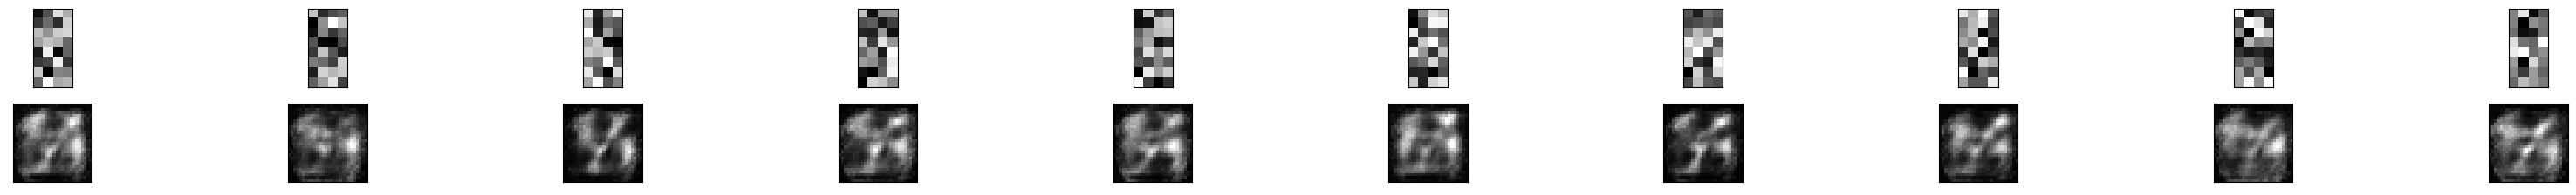

In [8]:
def plot_results(encoded_imgs, decoded_imgs, n=10):
    plt.figure(figsize=(40, 4))
    for i in range(n):
        # display encoded
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(encoded_imgs[i].reshape(8, 4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i, 0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
inpu = torch.rand((256, 32))
decoded_imgs = decoder(inpu)
plot_results(inpu, decoded_imgs.detach().numpy())

Ukážkové riešenie nájdete [na tomto odkaze](
https://github.com/DominikVranay/neural-networks-course/blob/d7f75c66a45050db3c064842172e28f844e6786f/labs/sources/lab09/lab09-autoencoder-solution.py).